# 11_02: fitting models

In [1]:
import math
import collections
import dataclasses
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

To demonstrate model fitting, we return to our gapminder data.

In [4]:
gm = pd.read_csv('gapminder2.csv', dtype_backend='pyarrow')

In [5]:
gm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41822 entries, 0 to 41821
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   country           41822 non-null  string[pyarrow]
 1   year              41822 non-null  int64[pyarrow] 
 2   region            41822 non-null  string[pyarrow]
 3   population        41822 non-null  double[pyarrow]
 4   life_expectancy   40629 non-null  double[pyarrow]
 5   age5_surviving    40490 non-null  double[pyarrow]
 6   babies_per_woman  41822 non-null  double[pyarrow]
 7   gdp_per_capita    41822 non-null  double[pyarrow]
dtypes: double[pyarrow](5), int64[pyarrow](1), string[pyarrow](2)
memory usage: 2.8 MB


We will take data from 1985 (the year of Live Aid!) and study the relation of child survival rates and the number of babies per woman. We tell pandas explicitly that the region is a categorical variable.

In [68]:
gdata = gm[gm.year == 1985].copy()

In [69]:
gdata['region'] = gdata['region'].astype('category')

In [71]:
gdata.region.dtype

CategoricalDtype(categories=['Africa', 'America', 'Asia', 'Europe', 'Oceania'], ordered=False, categories_dtype=string[pyarrow])

Let's make a quick scatter plot as we learned to do in the last chapter [chapter XX]. We'll map the continent to color, and the population to the area of the markers. Since we'll use this plot repeatedly, we make it into a function.

In [203]:
continent = gdata.region.map({'Africa': 'skyblue', 'Europe': 'gold', 'America': 'palegreen', 'Asia': 'coral', 'Oceania': 'teal'})
population = 1e-6 * gdata.population

def plotbabies():    
    gdata.plot.scatter('age5_surviving', 'babies_per_woman', c=continent, s=population,
                       linewidths=0.5, edgecolor='black', alpha=0.6, figsize=(5,3.5)); # alpha adds some transparency

We immediately observe that the number of babies per woman decreases with probability of their survival. This makes sense in a sad, pragmatic way.

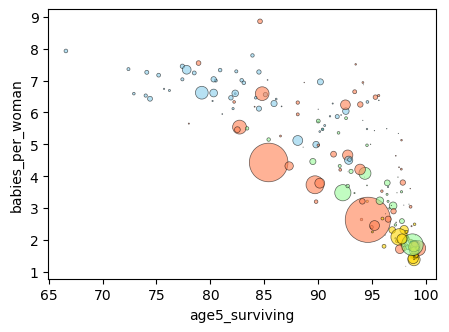

In [204]:
plotbabies()

We fit models using the very powerful Python package `statsmodels` (https://www.statsmodels.org). We will only scratch the surface of what statsmodels can do, and default to its `ols` method.

In [121]:
import statsmodels
import statsmodels.formula.api as smf

OLS stands for "ordinary least squares". [slide] "Least squares" means that models are fit by minimizing the sum of squared differences between model predictions and observations. Furthermore, "ordinary" here means that the model coefficients appear _linearly_ in the model formulas, multiplying the explanatory variables, or functions of the explanatory variables.

For OLS, the best-fit parameters can be found using the formulas of linear algebra. You can find them in any course or textbook of statistics. However the nice thing about Python and statsmodels is that you don't even need to remember them!

In `statsmodels`, we specify models using formulas in **tilde notation**. (Introduced by Chambers and Hastie in 1992 in S.)

The formulas go like "response variable (tilde) model terms". The simplest possible linear model is just a numerical constant, which is denoted 1.

In [123]:
constantmodel = smf.ols(formula='babies_per_woman ~ 1', data=gdata)

Once the model is defined, we fit it.

In [124]:
constantfit = constantmodel.fit()

There's only one parameter to this fit... and the conventional name for a constant parameter in a linear model is "Intercept".

In [125]:
constantfit.params

Intercept    4.296
dtype: float64

And it is in fact the mean of the data points.

In [126]:
gdata.babies_per_woman.mean()

4.296

Applying the model to our data, unsurprisingly, returns the intercept for every case.

In [127]:
constantfit.predict(gdata)

169      4.296
393      4.296
617      4.296
828      4.296
1052     4.296
         ...  
40930    4.296
41153    4.296
41351    4.296
41575    4.296
41783    4.296
Length: 195, dtype: float64

We can plot this prediction against the original data to evaluate the fit. Clearly not the greatest, since we do not capture any variation.

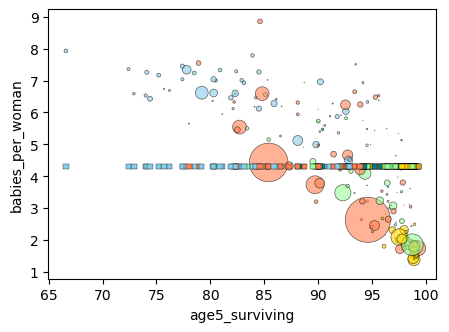

In [170]:
plotbabies()
pp.scatter(gdata.age5_surviving, constantfit.predict(gdata), color=continent,
           s=15, marker='s', edgecolor='k', linewidth=0.25); # small square markers with a think black edge

A slightly more complicated model involves separate constants for every continent.

In [129]:
groupfit = smf.ols(formula='babies_per_woman ~ 1 + region', data=gdata).fit()

In fact we get a common constant, plus offsets for all the groups minus one.

In [130]:
groupfit.params

Intercept            6.326296
region[T.America]   -2.745153
region[T.Asia]      -1.779896
region[T.Europe]    -4.440820
region[T.Oceania]   -1.737011
dtype: float64

To get all the group means we write the constant as -1.

In [131]:
groupfit2 = smf.ols(formula='babies_per_woman ~ -1 + region', data=gdata).fit()

In [132]:
groupfit2.params

region[Africa]     6.326296
region[America]    3.581143
region[Asia]       4.546400
region[Europe]     1.885476
region[Oceania]    4.589286
dtype: float64

In [133]:
# check: gdata.groupby('region', observed=True).babies_per_woman.mean()

The plot makes sense. All we're doing though is to show the average differences between continents. Asia, for one, has a huge variability that begs to be explained.

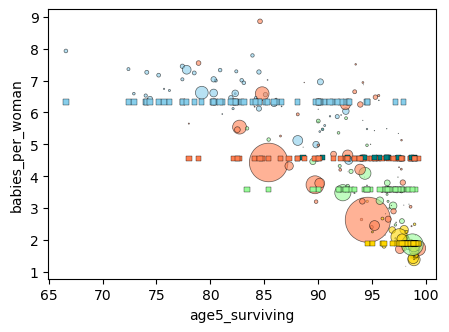

In [174]:
plotbabies()
pp.scatter(gdata.age5_surviving, groupfit2.predict(gdata), color=continent, s=15, marker='s', ec='k', lw=0.25);

Moving to more sophisticated models, we add child survival in the model. We use its value directly, so we call it a **main term** of the model.

In [135]:
survivingfit = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving', data=gdata).fit()

At least visually, our fit is improving.

The fit parameter age5_surviving tells us that for every additional percent of surviving children, the number of babies per woman decreases by 0.14. The constants now are larger, and they have a different meaning: the number of babies per woman for a hypothetical 5-year survival rate of 0%.

In [136]:
survivingfit.params

region[Africa]     19.213674
region[America]    18.130077
region[Asia]       18.690979
region[Europe]     16.947616
region[Oceania]    19.156939
age5_surviving     -0.153428
dtype: float64

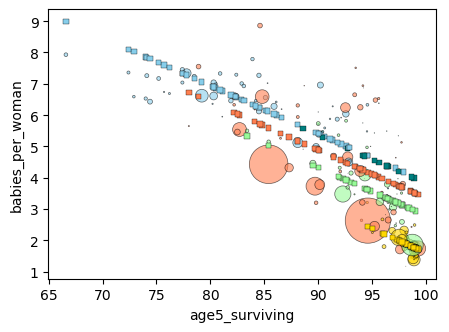

In [176]:
plotbabies()
pp.scatter(gdata.age5_surviving, survivingfit.predict(gdata), color=continent, s=15, marker='s', ec='k', lw=0.25);

If we wish to have a different slope for every region, we can replace the main term with an **interaction term** between `age5_surviving` and `region`. This shows that the effect of survival rates is so far weaker in Africa than in the other continents.

In [138]:
survivingfit2 = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving:region', data=gdata).fit()

In [139]:
survivingfit2.params

region[Africa]                    15.366983
region[America]                   26.928167
region[Asia]                      22.463712
region[Europe]                    25.025887
region[Oceania]                   27.781741
age5_surviving:region[Africa]     -0.107632
age5_surviving:region[America]    -0.246209
age5_surviving:region[Asia]       -0.194351
age5_surviving:region[Europe]     -0.235716
age5_surviving:region[Oceania]    -0.244265
dtype: float64

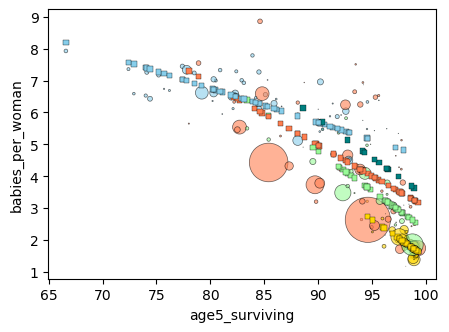

In [177]:
plotbabies()
pp.scatter(gdata.age5_surviving, survivingfit2.predict(gdata), color=continent, s=15, marker='s', ec='k', lw=0.25);

India and China (the two larger orange circles) are outliers with respect to the fit. Perhaps we can account for them by including another main term for population! That's indeed the case. The parameter value looks very small because the population is in millions; but basically one additional billion people reduces the number of babies per woman by two. The prediction is spot-on for India, but a bit too low for China.

In [200]:
twovariablefit = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving:region + population', data=gdata).fit()

In [201]:
twovariablefit.params

region[Africa]                    1.541442e+01
region[America]                   2.672689e+01
region[Asia]                      2.300482e+01
region[Europe]                    2.482028e+01
region[Oceania]                   2.767984e+01
age5_surviving:region[Africa]    -1.079450e-01
age5_surviving:region[America]   -2.436776e-01
age5_surviving:region[Asia]      -1.989314e-01
age5_surviving:region[Europe]    -2.332709e-01
age5_surviving:region[Oceania]   -2.431548e-01
population                       -2.044147e-09
dtype: float64

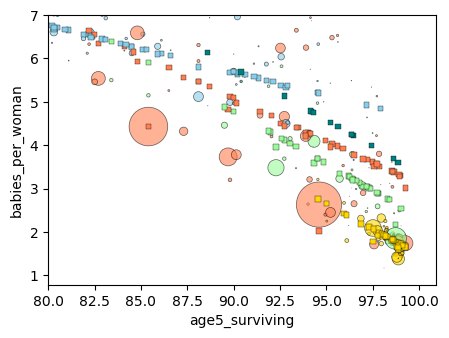

In [202]:
plotbabies()
pp.scatter(gdata.age5_surviving,
           twovariablefit.predict(gdata), color=continent, s=15, marker='s', ec='k', lw=0.25);
pp.axis(xmin=80, ymax=7);

Here's a quick cheatsheet for setting up models in the tilde notation, which is used in Python's statsmodels, but also in statistical languages such as R and S. The one thing we haven't demonstrated explicitly is a so-called **interaction**, where two explanatory variables enter the model multiplied together, and a including a function of an explanatory variable.

Well done! We've learned quite a bit. In the next video, we'll discuss how to tell actually how good any given model is.